In [2]:
from google.cloud import bigquery
import pandas as pd 
import chime   
import seaborn as sns
import pymc as pm
import numpy as np
client = bigquery.Client("gcp-wow-rwds-ai-checkout-dev")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/homebrew/lib/python3.11/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

In [4]:
import subprocess
import os

In [11]:
check = client.query(
"""
/*
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 AS (
    SELECT DISTINCT 
        booking_and_asset_number, 
        sku 
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2, 
    UNNEST(SPLIT(quoteline_skus_string, ",")) AS sku 
    WHERE booking_and_asset_number = "WOW20002643_Cadbury_1" --current_campaign_global_var 
    AND sku IS NOT NULL
    AND LOWER(sku) <> "npd"
    AND sku <> ""
);

CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 AS (
    SELECT DISTINCT 
        booking_number, 
        booking_and_asset_number,
        test_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2, 
    UNNEST(store_ids) AS test_store 
    WHERE booking_and_asset_number = "WOW20002643_Cadbury_1" --current_campaign_global_var
    AND test_store IS NOT NULL
);

CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions AS 
    SELECT 
        trading.booking_and_asset_number AS campaign_id,
        trading.media_start_date,
        trading.media_end_date,
        ass_campaign_period.Site, 
        CASE WHEN test_stores.test_store IS NOT NULL THEN "Test" ELSE "Control" END AS test_or_control, 
        --ass_campaign_period.Article,
        ass_campaign_period.TXNStartDate,
        ass_campaign_period.BasketKey,
        SUM(ass_campaign_period.TotalAmountIncldTax) AS sales_amount

    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_campaign_period
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2 trading
        ON ass_campaign_period.TXNStartDate >= trading.media_start_date 
        AND ass_campaign_period.TXNStartDate <= trading.media_end_date 
    INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 skus 
        ON skus.sku = ass_campaign_period.Article 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test_stores 
        ON CAST(test_stores.test_store AS INT64) = CAST(ass_campaign_period.Site AS INT64)
        
    WHERE trading.booking_and_asset_number = "WOW20002643_Cadbury_1" --current_campaign_global_var
    AND LOWER(ass_campaign_period.SalesChannelDescription) <> "online"
    AND ass_campaign_period.TXNStartDate >= trading.media_start_date 
    AND ass_campaign_period.TXNStartDate <= trading.media_end_date
    AND ass_campaign_period.SalesOrg = 1005
    GROUP BY ALL
;
*/
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions;
"""
).result()
transactions_df = check.to_dataframe()
chime.success()
transactions_df

,campaign_id,media_start_date,media_end_date,Site,test_or_control,TXNStartDate,BasketKey,sales_amount
0,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,1280,Control,2023-05-17,20230517165709008039341280,3.830000000
1,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,1280,Control,2023-05-17,20230517133620082074961280,15.700000000
2,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,1280,Control,2023-05-17,20230517174244083086391280,3.600000000
3,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,1280,Control,2023-05-17,20230517114516063057611280,3.830000000
4,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,1280,Control,2023-05-17,20230517163952061057251280,3.480000000
...,...,...,...,...,...,...,...,...
1304747,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,5631,Test,2023-05-23,20230523160056007000975631,8.700000000
1304748,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,5631,Test,2023-05-23,20230523131403064033845631,3.850000000
1304749,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,5631,Test,2023-05-23,20230523163056062024835631,1.590000000
1304750,WOW20002643_Cadbury_1,2023-05-17,2023-05-23,5631,Test,2023-05-23,20230523154921084018725631,7.700000000


In [6]:
check = client.query(
    f""" 
    with step_one AS (
        SELECT 
            baseline.*,
            CASE WHEN test.test_store IS NULL THEN "Control" ELSE "Test" END AS test_or_control
        FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
        LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test
            ON TRIM(test.booking_and_asset_number) = TRIM(baseline.campaign_id)
            AND TRIM(CAST(test.test_store AS STRING)) = TRIM(CAST(baseline.Site AS STRING))
        WHERE baseline.campaign_id = 'WOW20002643_Cadbury_1'
    ),
    step_two AS (
        SELECT 
            test_or_control,
            COUNT(DISTINCT Site) AS n_stores, 
            COUNT(DISTINCT CASE WHEN weeks_count = 13 THEN Site ELSE NULL END) AS has_13_wks_historical_sales
        FROM step_one 
        GROUP BY 1
    )

    SELECT 
        test_or_control, 
        SAFE_DIVIDE(CAST(has_13_wks_historical_sales AS FLOAT64) , CAST(n_stores AS FLOAT64)) AS perc_of_stores_with_13_wks_historical_sales 
    FROM step_two
    """
).result()

check_df = check.to_dataframe()

# Check if any group has less than 90% stores with 13 weeks of historical sales data
if any(check_df['perc_of_stores_with_13_wks_historical_sales'] < 0.9):
    print(f"Skipping campaign_id WOW20002643_Cadbury_1 as less than 90% of stores in either group have 13 weeks of historical sales data.")

In [15]:
check = client.query(
"""
with step_one AS (
SELECT baseline.*, baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, campaign.test_or_control --campaign_id, Site, stddev_sales_amount, sales_amount / weeks_count AS weekly_avg_sales_amount
FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
    ON baseline.campaign_id = campaign.campaign_id 
    AND baseline.Site = campaign.Site
WHERE baseline.campaign_id = "WOW20002643_Cadbury_1"
AND weeks_count = 13
) 
SELECT 
    test.campaign_id AS study_id, 
    test.Site AS test_store, 
    control.Site AS control_store, 
    ABS(test.weekly_avg_sales_amount / control.weekly_avg_sales_amount - 1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount - 1) AS abs_perc_diff
FROM step_one test
LEFT JOIN step_one control 
    ON test.Site <> control.Site 
WHERE test.test_or_control = "Test" 
AND control.test_or_control = "Control" 
"""
).result()
matched_pairs_input_df = check.to_dataframe()
chime.success()
matched_pairs_input_df.to_csv("../Match Maker/inputs/WOW20002643_Cadbury_1_Store_Pairs.csv", index = False)
matched_pairs_input_df

,study_id,test_store,control_store,abs_perc_diff
0,WOW20002643_Cadbury_1,2057,2853,0.159641
1,WOW20002643_Cadbury_1,2057,3161,0.664649
2,WOW20002643_Cadbury_1,2057,1380,0.807044
3,WOW20002643_Cadbury_1,2057,1056,0.316365
4,WOW20002643_Cadbury_1,2057,3141,0.241111
...,...,...,...,...
75163,WOW20002643_Cadbury_1,1279,1177,0.338202
75164,WOW20002643_Cadbury_1,1279,8881,200.246735
75165,WOW20002643_Cadbury_1,1279,7213,0.204343
75166,WOW20002643_Cadbury_1,1279,3193,0.309833


In [17]:
check = client.query(
"""
SELECT baseline.*, baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, campaign.test_or_control --campaign_id, Site, stddev_sales_amount, sales_amount / weeks_count AS weekly_avg_sales_amount
FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
    ON baseline.campaign_id = campaign.campaign_id 
    AND baseline.Site = campaign.Site
WHERE baseline.campaign_id = "WOW20002643_Cadbury_1"
AND weeks_count = 13
"""
).result()
historical_performance_df = check.to_dataframe()
chime.success()
historical_performance_df

,campaign_id,Site,mean_transactions,sales_amount,stddev_transactions,stddev_sales_amount,variance_transactions,min_transactions,max_transactions,weeks_count,total_transactions,weekly_avg_sales_amount,test_or_control
0,WOW20002643_Cadbury_1,1099,1233.461538,85875.440000000,264.144094,1533.145114,69772.102564,768,1856,13,16035,6605.803076923,Test
1,WOW20002643_Cadbury_1,5901,1423.000000,85816.210000000,321.563109,1173.561056,103402.833333,1024,2081,13,18499,6601.246923077,Test
2,WOW20002643_Cadbury_1,2702,1060.846154,60047.560000000,194.886653,892.283603,37980.807692,769,1483,13,13791,4619.043076923,Control
3,WOW20002643_Cadbury_1,3369,1227.923077,72764.670000000,295.231396,1397.199817,87161.576923,769,1952,13,15963,5597.282307692,Test
4,WOW20002643_Cadbury_1,3135,1429.538462,83568.450000000,312.709561,1530.652672,97787.269231,1025,2286,13,18584,6428.342307692,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,WOW20002643_Cadbury_1,3202,804.615385,48118.840000000,213.471910,1166.135752,45570.256410,509,1351,13,10460,3701.449230769,Test
1005,WOW20002643_Cadbury_1,5018,1135.846154,74510.510000000,226.128963,1195.340481,51134.307692,765,1648,13,14766,5731.577692308,Test
1006,WOW20002643_Cadbury_1,2502,1386.692308,88799.800000000,248.565680,1431.298843,61784.897436,1021,1967,13,18027,6830.753846154,Test
1007,WOW20002643_Cadbury_1,2703,1049.461538,59678.150000000,187.500051,804.299233,35156.269231,767,1462,13,13643,4590.626923077,Test


In [ ]:
cpp_executable = "../Match Maker/campaign_match_maker"
campaign_id = "WOW20002643_Cadbury_1"
input_csv = "../Match Maker/inputs/WOW20002643_Cadbury_1_Store_Pairs.csv"
print(f"Creating matched pairs: {campaign_id}")
    # Run the C++ program with the campaign_id
subprocess.run([cpp_executable, input_csv, campaign_id], check=True)

In [9]:
matched_pairs = pd.read_csv("../Match Maker/outputs/WOW20002643_Cadbury_1_global_matching.csv")
matched_pairs.head(10)

,test_store,control_store,abs_perc_diff
0,3109,1368,0.003003
1,4782,4857,0.003133
2,3261,3161,0.004060
3,3145,3221,0.004830
4,7014,7011,0.004981
5,1607,5661,0.005066
6,1353,3159,0.005113
7,2660,2601,0.005950
8,3331,2665,0.005969
9,2727,3141,0.006148


In [12]:
# Combine 'test_store' and 'control_store' into a single series
combined_stores = pd.concat([matched_pairs['test_store'], matched_pairs['control_store']])

# Filter transactions_df where 'Site' is in the combined stores
filtered_transactions = transactions_df[transactions_df['Site'].isin(combined_stores)]

In [ ]:
 # Filter transactions_df where 'Site' is in the combined stores
filtered_transactions = transactions_df[transactions_df['Site'].isin(combined_stores)]

print(f"Processing posterior distributions of sum_of_sales: WOW20002643_Cadbury_1")
## Posterior Distributions for total sum of sales 
# Assuming you have a dataframe `df` with the SQL query results
df = filtered_transactions

# Convert sales_amount to numeric, forcing any errors to NaN and dropping them
df['sales_amount'] = pd.to_numeric(df['sales_amount'], errors='coerce')
df.dropna(subset=['sales_amount'], inplace=True)

# Group transactions by store (Site) for posterior modeling
grouped = df.groupby(['Site', 'test_or_control'])

# Initialize an empty dictionary to store full posterior samples for each store
posterior_samples = {}
count = 0
# Iterate through each group (store-level) and model the sum of sales as a posterior distribution
for store, group in grouped:
    sales = group['sales_amount'].values  # extract individual transaction sales for the store
    count = count + 1
    # Check if sales is empty or non-numeric (additional guard)
    if len(sales) == 0 or not np.issubdtype(sales.dtype, np.number):
        
        print(f"Skipping store {store} due to invalid sales data")
        continue

    # Bayesian modeling of the sum of sales
    with pm.Model() as model:
        # Total number of transactions
        n_sales = len(sales)

        # Flat prior for the mean of the total sales across all transactions
        total_sum_sales = pm.Uniform("total_sum_sales", lower=n_sales * sales.min(), upper=n_sales * sales.max())

        # Per-transaction mean derived from the total sum
        per_transaction_mu = total_sum_sales / n_sales
        
        # Flat prior for the standard deviation of the sales per transaction
        sigma = pm.Uniform("sigma", lower=0, upper=sales.std() * 2)
        
        # Likelihood of observing sales per transaction
        sales_obs = pm.Normal("sales_obs", mu=per_transaction_mu, sigma=sigma, observed=sales)
        
        # Sampling from the posterior with increased tuning and sample size
        trace = pm.sample(2000, tune=2000, target_accept=0.95, return_inferencedata=True, progressbar=False)

        # Store the full posterior samples for the total sum of sales
        posterior_samples[store] = trace.posterior['total_sum_sales'].to_dataframe()
        print(f"{count} stores fit with posteriors\n")

# Convert the posterior samples into a dictionary for each store
# The key will be the store and the value will be a DataFrame of posterior samples
posterior_samples_dict = {store: df.reset_index(drop=True) for store, df in posterior_samples.items()}

# Example output for a specific store (the first one in the dictionary)
store_name = list(posterior_samples_dict.keys())[0]
chime.success() 
print(f"Posterior samples for store {store_name}:\n", posterior_samples_dict[store_name].head())

# Flatten the posterior_samples_dict into a DataFrame
# Stacking the store IDs and their corresponding posterior samples

flattened_samples = []
for store, posterior_df in posterior_samples.items():
    store_id = store[0]  # Extract the store ID
    test_or_control = store[1]  # Extract test or control group info
    posterior_df = posterior_df.reset_index(drop=True)  # Reset the index of the posterior samples
    posterior_df['store'] = store_id  # Add the store ID as a column
    posterior_df['test_or_control'] = test_or_control  # Add the test or control info
    flattened_samples.append(posterior_df)

# Concatenate all store samples into a single DataFrame
flattened_samples_df = pd.concat(flattened_samples, ignore_index=True)

# Merging posterior samples of sum_of_sales with historical performance in order to produce z-score distributions
# flattened_samples_df: Contains store, test_or_control, total_sum_sales
# campaign_data_df: Contains campaign_id, Site (store), stddev_sales_amount, weekly_avg_sales_amt
check = client.query(
f"""
    SELECT 
        baseline.*, 
        baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, 
        campaign.test_or_control 
    FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
    LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
        ON baseline.campaign_id = campaign.campaign_id 
        AND baseline.Site = campaign.Site
    WHERE baseline.campaign_id = 'WOW20002643_Cadbury_1'
    AND weeks_count = 13
"""
).result()
campaign_data_df = check.to_dataframe()

# Perform a left join
merged_df = pd.merge(flattened_samples_df, 
                    campaign_data_df[['campaign_id', 'Site', 'stddev_sales_amount', 'weekly_avg_sales_amount']],
                    left_on='store', right_on='Site', how='left')

# Drop the redundant 'Site' column (if needed)
merged_df = merged_df.drop(columns=['Site'])

# Output the merged DataFrame
print(merged_df.head(5))

print(f"Processing z-scores from posterior distribution of sum_of_sales: {campaign_id}")
# Convert 'total_sum_sales', 'weekly_avg_sales_amt', and 'stddev_sales_amount' to float
merged_df['total_sum_sales'] = merged_df['total_sum_sales'].astype(float)
merged_df['weekly_avg_sales_amount'] = merged_df['weekly_avg_sales_amount'].astype(float)
merged_df['stddev_sales_amount'] = merged_df['stddev_sales_amount'].astype(float)

# Ensure there are no zero values in stddev_sales_amt to avoid division errors
merged_df['stddev_sales_amount'].replace(0, np.nan, inplace=True)

# Calculate the campaign_z_score and create a new column
merged_df['campaign_z_score'] = (merged_df['total_sum_sales'] - merged_df['weekly_avg_sales_amount']) / merged_df['stddev_sales_amount']

# Output the resulting DataFrame with the new column
print(merged_df.head(5))
chime.success() 


In [18]:
# Assuming you have two DataFrames:
# flattened_samples_df: Contains store, test_or_control, total_sum_sales
# campaign_data_df: Contains campaign_id, Site (store), stddev_sales_amount, weekly_avg_sales_amt

# Perform a left join
merged_df = pd.merge(flattened_samples_df, 
                     historical_performance_df[['campaign_id', 'Site', 'stddev_sales_amount', 'weekly_avg_sales_amount']],
                     left_on='store', right_on='Site', how='left')

# Drop the redundant 'Site' column (if needed)
merged_df = merged_df.drop(columns=['Site'])

# Output the merged DataFrame
merged_df.head(5)

# Now merged_df contains the structure you wanted:
# campaign_id, store, test_or_control, total_sum_sales, weekly_avg_sales_amt, stddev_sales_amt


,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount
0,5647.598641,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209230769
1,5336.938676,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209230769
2,5394.556478,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209230769
3,5519.300500,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209230769
4,5358.087966,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209230769


In [19]:
# Convert 'total_sum_sales', 'weekly_avg_sales_amt', and 'stddev_sales_amount' to float
merged_df['total_sum_sales'] = merged_df['total_sum_sales'].astype(float)
merged_df['weekly_avg_sales_amount'] = merged_df['weekly_avg_sales_amount'].astype(float)
merged_df['stddev_sales_amount'] = merged_df['stddev_sales_amount'].astype(float)

# Ensure there are no zero values in stddev_sales_amt to avoid division errors
merged_df['stddev_sales_amount'].replace(0, np.nan, inplace=True)

# Calculate the campaign_z_score and create a new column
merged_df['campaign_z_score'] = (merged_df['total_sum_sales'] - merged_df['weekly_avg_sales_amount']) / merged_df['stddev_sales_amount']

# Output the resulting DataFrame with the new column
merged_df.head(5)


,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount,campaign_z_score
0,5647.598641,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209231,1.569013
1,5336.938676,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209231,1.252786
2,5394.556478,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209231,1.311436
3,5519.300500,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209231,1.438416
4,5358.087966,1056,Control,WOW20002643_Cadbury_1,982.39434,4106.209231,1.274314


In [24]:
# Import necessary libraries
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# Assume 'merged_df' and 'matched_pairs' DataFrames are already loaded and preprocessed
# 'merged_df' contains columns: 'store', 'test_or_control', 'campaign_z_score'
# 'matched_pairs' contains columns: 'test_store', 'control_store'

# Ensure 'merged_df' is sorted by 'store' and 'test_or_control'
merged_df = merged_df.sort_values(by=['store', 'test_or_control'])

# Initialize a list to store the posterior samples of percentage differences
posterior_percentage_differences = []

# Set a small constant to handle division by zero in percentage difference calculation
epsilon = 1e-6

# Iterate through each pair of test and control stores in 'matched_pairs'
for _, pair in matched_pairs.iterrows():
    test_store = pair['test_store']
    control_store = pair['control_store']
    
    # Extract posterior samples of z-scores for test and control stores
    test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
    control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
    
    # Ensure that the number of posterior samples matches between test and control stores
    if len(test_store_posteriors) != len(control_store_posteriors):
        raise ValueError(f"Mismatch in posterior sample sizes between test store {test_store} and control store {control_store}")
    
    # Compute the percentage difference using the original formula
    # Handle small denominators by adding epsilon
    with np.errstate(divide='ignore', invalid='ignore'):
        perc_diff = (test_store_posteriors - control_store_posteriors) / (np.abs(control_store_posteriors))
    
    # Store the percentage difference samples along with the test and control store ids
    posterior_percentage_differences.append(pd.DataFrame({
        'test_store': test_store,
        'control_store': control_store,
        'posterior_perc_diff': perc_diff
    }))

# Concatenate all the percentage difference DataFrames
posterior_percentage_differences_df = pd.concat(posterior_percentage_differences, ignore_index=True)

# Create an index that identifies which pair each percentage difference belongs to
pair_labels = posterior_percentage_differences_df.apply(lambda row: (row['test_store'], row['control_store']), axis=1)

# Create a categorical variable to get codes for each unique pair
pair_categories = pd.Categorical(pair_labels)
pair_indices = pair_categories.codes  # This will map each observation to a store pair index
unique_pairs = pair_categories.categories

# Now fit the hierarchical Bayesian model with adjusted priors
with pm.Model() as model:
    # Prior for the global mean percentage difference (mu_pop)
    # Centered at 0.0 with a wider standard deviation to allow for both positive and negative effects
    mu_pop = pm.Normal('mu_pop', mu=0.0, sigma=0.005)
    
    # Prior for the variability of store pair effects around the global mean (sigma_pop)
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=0.00125)
    
    # Store-pair-specific effects (using centered parameterization)
    store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
    
    # Assign the correct store_pair_effect to each percentage difference using pair_indices
    store_pair_effects_repeated = store_pair_effects[pair_indices]
    
    # Prior for the observational standard deviation (sigma_obs)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.005)
    
    # Likelihood: Using normal distribution
    observed_perc_diff = pm.Normal(
        'observed_perc_diff',
        mu=store_pair_effects_repeated,
        sigma=sigma_obs,
        observed=posterior_percentage_differences_df['posterior_perc_diff'].values
    )
    
    # Sample from the posterior distribution
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )

# Summarize and analyze the trace
summary_df = az.summary(
    trace,
    var_names=['mu_pop', 'sigma_pop', 'sigma_obs', 'store_pair_effects'],
    hdi_prob=0.95
)

# Map store pairs to store_pair_effects for easier interpretation
store_pair_mapping = {f"store_pair_effects[{i}]": unique_pairs[i] for i in range(len(unique_pairs))}

# Replace the index in summary_df with the store pair labels
summary_df = summary_df.rename(index=store_pair_mapping)

# Convert 'mu_pop' and 'store_pair_effects' to percentages
summary_df.loc['mu_pop', ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100

# Since store pair labels are tuples, format them as strings for readability
summary_df.index = summary_df.index.map(lambda x: f"{int(x[0])}_{int(x[1])}" if isinstance(x, tuple) else x)

# Multiply store_pair_effects by 100 to get percentages
store_pair_indices = [i for i in summary_df.index if i not in ['mu_pop', 'sigma_pop', 'sigma_obs']]
summary_df.loc[store_pair_indices, ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100

# Output the summary DataFrame with relevant columns
print(summary_df[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4986 seconds.


              mean      sd  hdi_2.5%  hdi_97.5%
mu_pop       3.600   0.500     2.600      4.500
sigma_pop    0.067   0.003     0.061      0.072
sigma_obs   26.682   0.002    26.677     26.687
1103_3242  315.400  26.500   262.900    364.700
1114_1380    5.200   6.500    -7.600     17.600
1168_1111    3.300   6.400    -9.000     15.900
1176_3433   49.700   7.500    34.500     64.100
1190_3268    2.600   6.500    -9.900     15.500
1200_3800    0.200   6.600   -12.500     13.400
1216_7222    3.000   6.600    -9.900     15.600
1244_5615    3.700   6.600    -9.400     16.500
1274_2853    1.200   6.500   -11.800     13.500
1284_1135    2.000   6.500   -11.000     14.300
1302_1092    3.500   6.700   -10.000     16.500
1339_4372    1.500   6.400   -10.900     14.500
1341_2667    5.100   6.800    -8.000     18.800
1343_2755   16.300   6.600     3.700     29.100
1344_2898    2.000   6.500   -10.600     14.700
1353_3159    4.700   6.500    -7.800     17.300
1377_1800   92.100   9.900    73.000    

In [25]:
# Convert the index into a DataFrame for easier handling
summary_df = summary_df.reset_index()

# Separate rows where the index is not a store pair (e.g., 'mu_pop', 'sigma_pop')
non_store_rows = summary_df[summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Filter out only the store pair rows for processing
store_pair_rows = summary_df[~summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Extract test_store and control_store from the store pair rows
store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')

# Convert store IDs to integers
store_pair_rows['test_store'] = store_pair_rows['test_store'].astype(float).astype(int)
store_pair_rows['control_store'] = store_pair_rows['control_store'].astype(float).astype(int)

# Drop the original 'index' column from store pair rows
store_pair_rows.drop(columns=['index'], inplace=True)

# Combine the population-level rows back with the processed store pair rows
summary_df_processed = pd.concat([non_store_rows, store_pair_rows], ignore_index=True)

# Display the processed DataFrame
summary_df_processed

/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_3069/2717524552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_3069/2717524552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv9q

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,test_store,control_store
0,mu_pop,3.600,0.500,2.600,4.500,0.000,0.000,10977.0,6590.0,1.0,NaN,NaN
1,sigma_pop,0.067,0.003,0.061,0.072,0.000,0.000,3432.0,4826.0,1.0,NaN,NaN
2,sigma_obs,26.682,0.002,26.677,26.687,0.000,0.000,15636.0,5521.0,1.0,NaN,NaN
3,NaN,315.400,26.500,262.900,364.700,0.004,0.003,3511.0,4792.0,1.0,1103.0,3242.0
4,NaN,5.200,6.500,-7.600,17.600,0.001,0.001,17017.0,6013.0,1.0,1114.0,1380.0
5,NaN,3.300,6.400,-9.000,15.900,0.000,0.001,18159.0,6061.0,1.0,1168.0,1111.0
6,NaN,49.700,7.500,34.500,64.100,0.001,0.001,6843.0,6433.0,1.0,1176.0,3433.0
7,NaN,2.600,6.500,-9.900,15.500,0.000,0.001,17800.0,5795.0,1.0,1190.0,3268.0
8,NaN,0.200,6.600,-12.500,13.400,0.000,0.001,18440.0,5295.0,1.0,1200.0,3800.0
9,NaN,3.000,6.600,-9.900,15.600,0.001,0.001,16768.0,5596.0,1.0,1216.0,7222.0


In [35]:
pd.set_option('display.float_format', '{:,.2f}'.format)
check = client.query(
f"""
with step_one AS (
    SELECT 
        test.campaign_id, 
        test.Site AS test_store, 
        control.Site AS control_store, 
        test.total_sales_campaign_period AS test_campaign_sales,
        control.total_sales_campaign_period AS control_campaign_sales, 
        SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count) AS test_weekly_avg_sales_amt, 
        SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count) AS control_weekly_avg_sales_amt, 
        test.stddev_sales_amount AS test_stddev_sales_amt, 
        control.stddev_sales_amount AS control_stddev_sales_amt, 
        SAFE_DIVIDE((test.total_sales_campaign_period - SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count)) , test.stddev_sales_amount) AS test_z_score, 
        SAFE_DIVIDE((control.total_sales_campaign_period - SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count)) , control.stddev_sales_amount) AS control_z_score
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 test 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 control
        ON test.Site <> control.Site 
    WHERE test.campaign_id = 'WOW20002643_Cadbury_1'
    AND control.campaign_id = 'WOW20002643_Cadbury_1'
    AND test.test_or_control = "Test" 
    AND control.test_or_control = "Control" 
    AND test.weeks_count = 13
    AND control.weeks_count = 13
) 
SELECT 
    *, 
    CASE WHEN test_z_score < 0 OR control_z_score < 0 THEN ((SAFE_DIVIDE(test_z_score , control_z_score) - 1) * -1) * 100 ELSE (SAFE_DIVIDE(test_z_score , control_z_score) -1) * 100 END AS z_score_perc_diff_old,
    (test_z_score - control_z_score) / ABS(control_z_score) AS z_score_perc_diff_equivalent,
    (test_z_score - control_z_score) / (ABS(test_z_score) + ABS(control_z_score)) AS z_score_perc_diff_new, 
    (((test_z_score * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt) - 1 AS test_percentage_increase_vs_expectation,
    (((control_z_score * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt) -1 AS control_percentage_increase_vs_expectation,
    (((test_z_score - control_z_score) * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt AS test_increase,
    (((control_z_score - test_z_score) * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt AS control_increase
FROM step_one
"""
).result()
check_df = check.to_dataframe()
chime.success() 
result_df = check_df.merge(matched_pairs, on=['test_store', 'control_store'], how='inner')
result_df

,campaign_id,test_store,control_store,test_campaign_sales,control_campaign_sales,test_weekly_avg_sales_amt,control_weekly_avg_sales_amt,test_stddev_sales_amt,control_stddev_sales_amt,test_z_score,control_z_score,z_score_perc_diff_old,z_score_perc_diff_equivalent,z_score_perc_diff_new,test_percentage_increase_vs_expectation,control_percentage_increase_vs_expectation,test_increase,control_increase,abs_perc_diff
0,WOW20002643_Cadbury_1,3138,1422,3414.940000000,4080.780000000,"2,787.00","2,737.20",652.98,655.37,0.96,2.05,-53.09,-0.53,-0.36,-1.04,0.05,-2.09,0.09,0.02
1,WOW20002643_Cadbury_1,2565,3275,10347.690000000,9719.410000000,"8,157.57","8,299.10","1,546.04","1,500.17",1.42,0.95,49.63,0.50,0.20,-0.58,-1.05,-0.53,-1.47,0.05
2,WOW20002643_Cadbury_1,3261,3161,8470.230000000,8510.240000000,"6,361.63","6,337.93","1,351.11","1,351.54",1.56,1.61,-2.90,-0.03,-0.01,-0.44,-0.39,-1.05,-0.95,0.00
3,WOW20002643_Cadbury_1,2259,2512,5965.630000000,5846.680000000,"4,160.23","4,137.33",772.29,781.51,2.34,2.19,6.88,0.07,0.03,0.34,0.19,-0.85,-1.15,0.02
4,WOW20002643_Cadbury_1,2605,3341,7199.800000000,7385.110000000,"5,601.42","5,625.58","1,063.69","1,073.36",1.50,1.64,-8.33,-0.08,-0.04,-0.50,-0.36,-1.14,-0.86,0.01
5,WOW20002643_Cadbury_1,2620,4304,5912.300000000,7641.320000000,"4,701.29","4,639.45",932.26,919.27,1.30,3.27,-60.22,-0.60,-0.43,-0.70,1.27,-2.97,0.97,0.03
6,WOW20002643_Cadbury_1,2682,2625,7088.480000000,8352.340000000,"5,844.57","5,840.00","1,092.87","1,116.18",1.14,2.25,-49.43,-0.49,-0.33,-0.86,0.25,-2.11,0.11,0.02
7,WOW20002643_Cadbury_1,2660,2601,7069.410000000,7539.040000000,"5,489.06","5,496.35","1,025.38","1,030.14",1.54,1.98,-22.27,-0.22,-0.13,-0.46,-0.02,-1.44,-0.56,0.01
8,WOW20002643_Cadbury_1,1176,3433,2069.510000000,90.610000000,"1,817.12",93.76,498.81,30.19,0.51,-0.10,585.02,5.85,1.00,-1.49,-2.10,-0.39,-1.61,33.90
9,WOW20002643_Cadbury_1,4049,1056,4636.410000000,5330.590000000,"4,125.78","4,106.21",969.49,982.39,0.53,1.25,-57.74,-0.58,-0.41,-1.47,-0.75,-1.72,-0.28,0.02


In [36]:
# Assuming merged_df contains 'test_store', 'control_store', and 'empirical_percentage_diff'
# Ensure that 'test_store' and 'control_store' in merged_df are integers for joining
result_df['test_store'] = result_df['test_store'].astype(int)
result_df['control_store'] = result_df['control_store'].astype(int)
result_df['z_score_perc_diff_equivalent'] = result_df['z_score_perc_diff_equivalent'] * 100
pd.set_option('display.float_format', '{:,.2f}'.format)

In [55]:

# Join the processed summary dataframe with the merged_df on test_store and control_store
comparison_df = pd.merge(
    summary_df_processed[['test_store', 'control_store', 'mean']],
    result_df[['test_store', 'control_store', 'z_score_perc_diff_equivalent']],  # Keep the relevant columns from merged_df
    on=['test_store', 'control_store'],
    how='left'
)

# Rename the columns for clarity
comparison_df = comparison_df.rename(columns={
    'mean': 'pymc_percentage_diff',
    'empirical_percentage_diff': 'empirical_percentage_diff'
})

# Display the merged dataframe for comparison
comparison_df['pymc_percentage_diff'] = comparison_df['pymc_percentage_diff'].round(2)
# Adding the campaign_id column to the DataFrame
comparison_df.insert(0, 'campaign_id', 'WOW20002643_Cadbury_1')

# Display the updated DataFrame

values_to_exclude = [3242, 3433, 1145, 8882, 1288, 2755, 1800, 1393, 4366, 2308, 8881, 2665]  # Replace with the actual values you want to exclude
filtered_df = comparison_df[~comparison_df['control_store'].isin(values_to_exclude)]
filtered_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20002643_Cadbury_1,NaN,NaN,3.60,NaN
1,WOW20002643_Cadbury_1,NaN,NaN,0.07,NaN
2,WOW20002643_Cadbury_1,NaN,NaN,26.68,NaN
4,WOW20002643_Cadbury_1,"1,114.00","1,380.00",5.20,38.31
5,WOW20002643_Cadbury_1,"1,168.00","1,111.00",3.30,-2.35
7,WOW20002643_Cadbury_1,"1,190.00","3,268.00",2.60,-15.09
8,WOW20002643_Cadbury_1,"1,200.00","3,800.00",0.20,-68.22
9,WOW20002643_Cadbury_1,"1,216.00","7,222.00",3.00,-9.78
10,WOW20002643_Cadbury_1,"1,244.00","5,615.00",3.70,3.05
11,WOW20002643_Cadbury_1,"1,274.00","2,853.00",1.20,-45.97


In [56]:
test_comparison_df = filtered_df
# Step 1: Identify the rows to keep (excluding sigma parameter rows)
rows_to_keep = test_comparison_df.groupby('campaign_id').apply(lambda x: pd.concat([x.iloc[[0]], x.iloc[3:]]))
test_comparison_df = rows_to_keep.reset_index(drop=True)

# Step 2: Identify the "mu_pop" rows
mu_pop_mask = test_comparison_df['test_store'].isna() & test_comparison_df['control_store'].isna() & test_comparison_df['pymc_percentage_diff'].notna()

# Step 3: Fill in "mu_pop" for test_store and control_store in these rows
test_comparison_df.loc[mu_pop_mask, ['test_store', 'control_store']] = 'mu_pop'

# Step 4: Calculate the mean of z_score_perc_diff_equivalent for each campaign_id
# Exclude the mu_pop rows from this calculation
z_score_means = test_comparison_df[~mu_pop_mask].groupby('campaign_id')['z_score_perc_diff_equivalent'].mean()

# Step 5: Update the z_score_perc_diff_equivalent for the "mu_pop" rows with this mean
test_comparison_df.loc[mu_pop_mask, 'z_score_perc_diff_equivalent'] = test_comparison_df.loc[mu_pop_mask, 'campaign_id'].map(z_score_means)

# Display the updated dataframe
test_comparison_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20002643_Cadbury_1,mu_pop,mu_pop,3.60,-13.05
1,WOW20002643_Cadbury_1,"1,114.00","1,380.00",5.20,38.31
2,WOW20002643_Cadbury_1,"1,168.00","1,111.00",3.30,-2.35
3,WOW20002643_Cadbury_1,"1,190.00","3,268.00",2.60,-15.09
4,WOW20002643_Cadbury_1,"1,200.00","3,800.00",0.20,-68.22
5,WOW20002643_Cadbury_1,"1,216.00","7,222.00",3.00,-9.78
6,WOW20002643_Cadbury_1,"1,244.00","5,615.00",3.70,3.05
7,WOW20002643_Cadbury_1,"1,274.00","2,853.00",1.20,-45.97
8,WOW20002643_Cadbury_1,"1,284.00","1,135.00",2.00,-30.92
9,WOW20002643_Cadbury_1,"1,302.00","1,092.00",3.50,2.40


In [57]:
test_comparison_df.to_csv("~/Downloads/Regularization2.csv", index=False)


Iteration 1/80
Testing sigma: 0.001400
Processing posterior distribution of percentage difference in z-scores: WOW20002643_Cadbury_1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1009 seconds.


Percentage within range: 45.68%
Percentage exact match: 0.00%
Overfitting. Decreasing sigma to 0.001300 for next iteration.

Iteration 2/80
Testing sigma: 0.001300
Processing posterior distribution of percentage difference in z-scores: WOW20002643_Cadbury_1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1183 seconds.


Percentage within range: 72.84%
Percentage exact match: 1.23%
Overfitting. Decreasing sigma to 0.001200 for next iteration.

Iteration 3/80
Testing sigma: 0.001200
Processing posterior distribution of percentage difference in z-scores: WOW20002643_Cadbury_1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1909 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Percentage within range: 93.83%
Percentage exact match: 9.88%
Underfitting. Increasing sigma to 0.001225 for next iteration.

Iteration 4/80
Testing sigma: 0.001225
Processing posterior distribution of percentage difference in z-scores: WOW20002643_Cadbury_1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1142 seconds.


Percentage within range: 88.89%
Percentage exact match: 4.94%
Acceptance criteria met. Stopping optimization.

Optimization complete.
Optimal sigma: 0.001225
Final percentage within range: 88.89%
Final percentage exact match: 4.94%

Final Model Summary:
                        mean   sd  hdi_2.5%  hdi_97.5%
mu_pop                  0.04 0.01      0.03       0.05
sigma_pop               0.05 0.00      0.04       0.06
sigma_obs              26.68 0.00     26.68      26.69
store_pair_effects[0]   1.88 0.27      1.35       2.40
store_pair_effects[1]   0.05 0.05     -0.05       0.15
store_pair_effects[2]   0.04 0.05     -0.06       0.13
store_pair_effects[3]   0.31 0.06      0.18       0.43
store_pair_effects[4]   0.03 0.05     -0.07       0.13
store_pair_effects[5]   0.02 0.05     -0.08       0.12
store_pair_effects[6]   0.03 0.05     -0.06       0.13
store_pair_effects[7]   0.04 0.05     -0.06       0.14
store_pair_effects[8]   0.02 0.05     -0.08       0.12
store_pair_effects[9]   0.03 0.

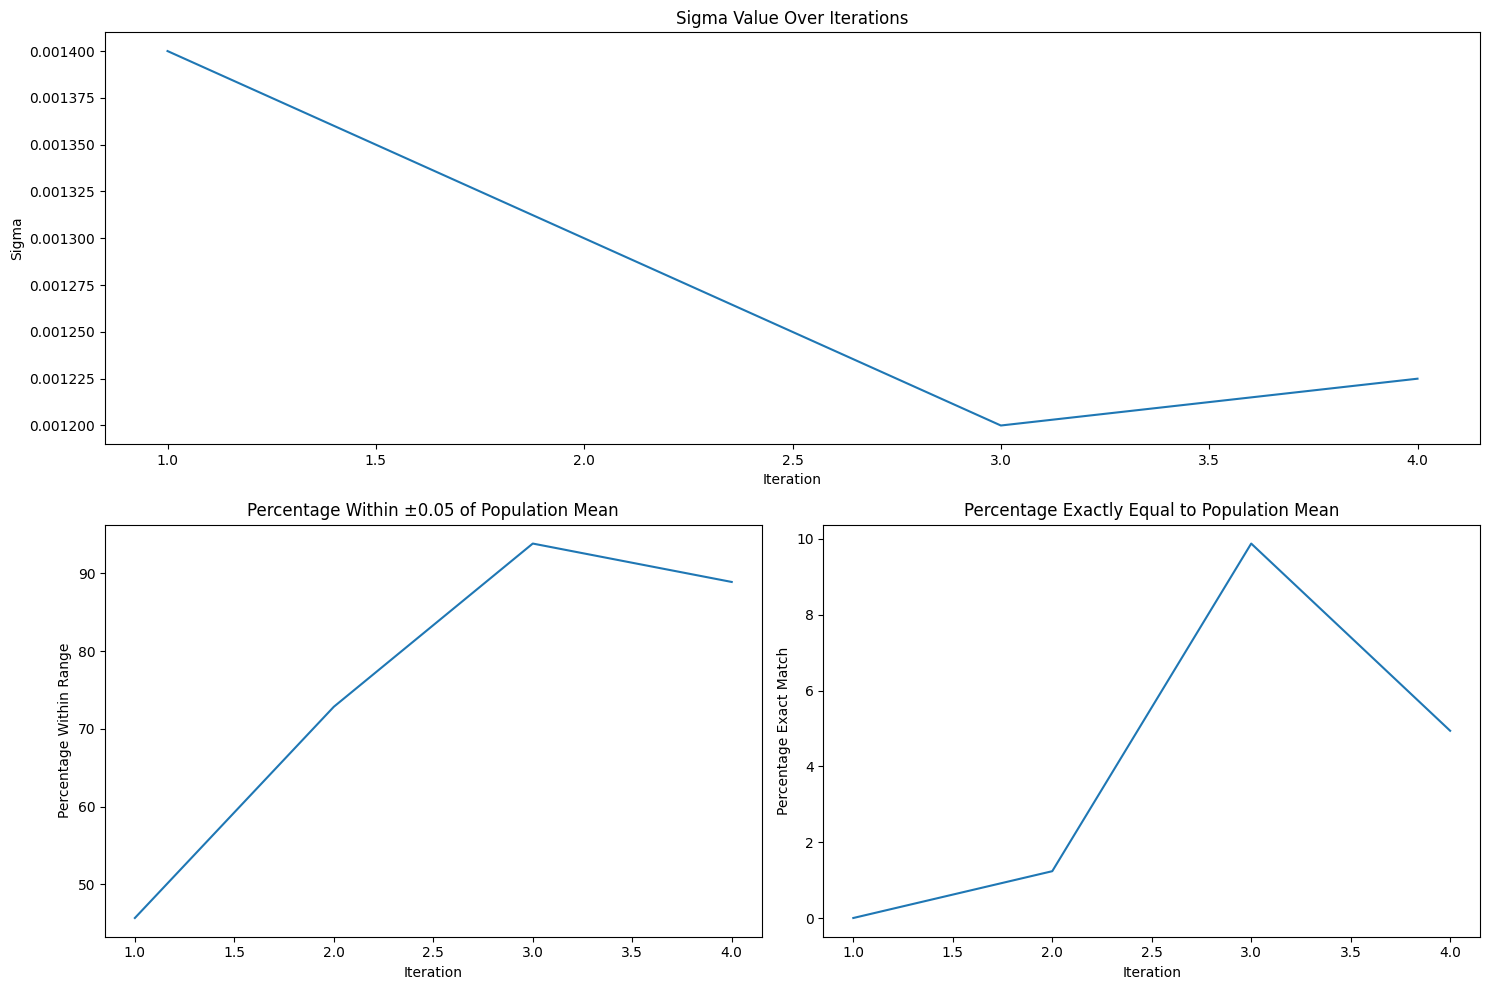

In [62]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

def run_model(sigma_value, merged_df, matched_pairs):
    
    # Initialize a list to store the posterior samples of percentage differences
    posterior_percentage_differences = []

    # Set a small constant to handle division by zero in percentage difference calculation
    epsilon = 1e-6

    print(f"Processing posterior distribution of percentage difference in z-scores: {campaign_id}")
    # Iterate through each pair of test and control stores in 'matched_pairs'
    for _, pair in matched_pairs.iterrows():
        test_store = pair['test_store']
        control_store = pair['control_store']
        
        # Extract posterior samples of z-scores for test and control stores
        test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
        control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
        
        # Ensure that the number of posterior samples matches between test and control stores
        if len(test_store_posteriors) != len(control_store_posteriors):
            raise ValueError(f"Mismatch in posterior sample sizes between test store {test_store} and control store {control_store}")
        
        # Compute the percentage difference using the original formula
        # Handle small denominators by adding epsilon
        with np.errstate(divide='ignore', invalid='ignore'):
            perc_diff = (test_store_posteriors - control_store_posteriors) / (np.abs(control_store_posteriors))
        
        # Store the percentage difference samples along with the test and control store ids
        posterior_percentage_differences.append(pd.DataFrame({
            'test_store': test_store,
            'control_store': control_store,
            'posterior_perc_diff': perc_diff
        }))

    # Concatenate all the percentage difference DataFrames
    posterior_percentage_differences_df = pd.concat(posterior_percentage_differences, ignore_index=True)

    # Create an index that identifies which pair each percentage difference belongs to
    pair_labels = posterior_percentage_differences_df.apply(lambda row: (row['test_store'], row['control_store']), axis=1)

    # Create a categorical variable to get codes for each unique pair
    pair_categories = pd.Categorical(pair_labels)
    pair_indices = pair_categories.codes  # This will map each observation to a store pair index
    unique_pairs = pair_categories.categories

    with pm.Model() as model:
        # Prior for the global mean percentage difference (mu_pop)
        # Centered at 0.0 with a wider standard deviation to allow for both positive and negative effects
        mu_pop = pm.Normal('mu_pop', mu=0.0, sigma=0.005)

        # trial sigma_pop 
        sigma_pop = pm.HalfNormal('sigma_pop', sigma=sigma_value)

        # Store-pair-specific effects (using centered parameterization)
        store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
        
        # Assign the correct store_pair_effect to each percentage difference using pair_indices
        store_pair_effects_repeated = store_pair_effects[pair_indices]
        
        # Prior for the observational standard deviation (sigma_obs)
        sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.005)
        
        # Likelihood: Using normal distribution
        observed_perc_diff = pm.Normal(
            'observed_perc_diff',
            mu=store_pair_effects_repeated,
            sigma=sigma_obs,
            observed=posterior_percentage_differences_df['posterior_perc_diff'].values
        )
        
        # Sample from the posterior distribution
        trace = pm.sample(
            draws=2000,
            tune=2000,
            target_accept=0.95,
            return_inferencedata=True
        )
    
    # Summarize and analyze the trace
    summary_df = az.summary(
        trace,
        var_names=['mu_pop', 'sigma_pop', 'sigma_obs', 'store_pair_effects'],
        hdi_prob=0.95
    )
    
    return trace, summary_df


def evaluate_model(summary_df):
    population_mean = summary_df.loc['mu_pop', 'mean']
    group_estimates = summary_df.loc[summary_df.index.str.contains('store_'), 'mean']
    
    # Calculate the percentage of group estimates within ±0.05 of the population mean
    within_range = np.abs(group_estimates - population_mean) <= 0.05
    percentage_within_range = np.mean(within_range) * 100
    
    # Calculate the percentage of estimates exactly equal to the population mean (underfitting)
    percentage_exact = np.mean(np.abs(group_estimates - population_mean) < 1e-6) * 100
    
    return percentage_within_range, percentage_exact

def optimize_sigma(merged_df, matched_pairs, sigma_range=(0.0008, 0.002), coarse_step=0.0001, fine_step=0.000025, max_iterations=80):
    lower, upper = sigma_range
    start_sigma = (lower + upper) / 2
    current_sigma = start_sigma
    results = []
    tested_sigmas = set()
    initial_direction = None
    use_fine_step = False
    optimal_trace = None
    optimal_summary = None
    
    for iteration in range(max_iterations):
        print(f"\nIteration {iteration + 1}/{max_iterations}")
        print(f"Testing sigma: {current_sigma:.6f}")
        
        if current_sigma in tested_sigmas:
            print("Arrived at a previously tested sigma. No optimal sigma found.")
            break
        
        tested_sigmas.add(current_sigma)
        
        trace, summary_df = run_model(current_sigma, merged_df, matched_pairs)
        percentage_within_range, percentage_exact = evaluate_model(summary_df)
        
        results.append({
            'iteration': iteration + 1,
            'sigma': current_sigma,
            'percentage_within_range': percentage_within_range,
            'percentage_exact': percentage_exact
        })
        
        print(f"Percentage within range: {percentage_within_range:.2f}%")
        print(f"Percentage exact match: {percentage_exact:.2f}%")
        
        if percentage_within_range >= 80 and percentage_exact < 5:
            print("Acceptance criteria met. Stopping optimization.")
            optimal_trace = trace
            optimal_summary = summary_df
            break
        
        is_overfitting = percentage_within_range < 80
        is_underfitting = percentage_exact >= 5
        
        if is_overfitting and is_underfitting:
            print("Both overfitting and underfitting detected. This is an unexpected state.")
            break
        
        if initial_direction is None:
            initial_direction = 'overfit' if is_overfitting else 'underfit'
            step = coarse_step
        elif (is_overfitting and initial_direction == 'underfit') or (is_underfitting and initial_direction == 'overfit'):
            if not use_fine_step:
                use_fine_step = True
                step = fine_step
                initial_direction = 'overfit' if is_overfitting else 'underfit'  # Reset direction for fine-tuning
            else:
                print("Direction changed again during fine-tuning. No optimal sigma found.")
                break
        
        if is_overfitting:
            current_sigma = max(lower, current_sigma - step)
            print(f"Overfitting. Decreasing sigma to {current_sigma:.6f} for next iteration.")
        elif is_underfitting:
            current_sigma = min(upper, current_sigma + step)
            print(f"Underfitting. Increasing sigma to {current_sigma:.6f} for next iteration.")
        
        if current_sigma == lower or current_sigma == upper:
            print("Reached the boundary of the sigma range. Stopping optimization.")
            break
    
    results_df = pd.DataFrame(results)
    
    if len(results_df) == max_iterations:
        print("Reached maximum iterations without finding optimal sigma.")
    elif optimal_trace is None:
        print("No optimal sigma found within the given range.")
    else:
        optimal_sigma = results_df.loc[results_df['iteration'].idxmax(), 'sigma']
        print(f"\nOptimization complete.")
        print(f"Optimal sigma: {optimal_sigma:.6f}")
        print(f"Final percentage within range: {results_df['percentage_within_range'].iloc[-1]:.2f}%")
        print(f"Final percentage exact match: {results_df['percentage_exact'].iloc[-1]:.2f}%")
    
    return results_df, optimal_trace, optimal_summary

# Usage example (assuming merged_df and matched_pairs are already prepared)
results_df, optimal_trace, optimal_summary = optimize_sigma(merged_df, matched_pairs)

# If you want to display the final results:
if optimal_summary is not None:
     print("\nFinal Model Summary:")
     print(optimal_summary[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])

# Plot the optimization results
def plot_optimization_results(results_df):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(results_df['iteration'], results_df['sigma'])
    plt.xlabel('Iteration')
    plt.ylabel('Sigma')
    plt.title('Sigma Value Over Iterations')

    plt.subplot(2, 2, 3)
    plt.plot(results_df['iteration'], results_df['percentage_within_range'])
    plt.xlabel('Iteration')
    plt.ylabel('Percentage Within Range')
    plt.title('Percentage Within ±0.05 of Population Mean')

    plt.subplot(2, 2, 4)
    plt.plot(results_df['iteration'], results_df['percentage_exact'])
    plt.xlabel('Iteration')
    plt.ylabel('Percentage Exact Match')
    plt.title('Percentage Exactly Equal to Population Mean')

    plt.tight_layout()
    plt.show()

# Plot results
plot_optimization_results(results_df)

In [81]:
#summary_df
#store_pair_mapping
summary_df = summary_df.rename(index=store_pair_mapping)
#summary_df
#summary_df[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] /= 100
summary_df.index = summary_df.index.map(lambda x: f"{int(x[0])}_{int(x[1])}" if isinstance(x, tuple) else x)
summary_df

,level_0,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,0,mu_pop,3.60,0.50,2.60,4.50,0.00,0.00,"10,977.00","6,590.00",1.00
1,1,sigma_pop,0.07,0.00,0.06,0.07,0.00,0.00,"3,432.00","4,826.00",1.00
2,2,sigma_obs,26.68,0.00,26.68,26.69,0.00,0.00,"15,636.00","5,521.00",1.00
3,3,1103_3242,315.40,26.50,262.90,364.70,0.00,0.00,"3,511.00","4,792.00",1.00
4,4,1114_1380,5.20,6.50,-7.60,17.60,0.00,0.00,"17,017.00","6,013.00",1.00
5,5,1168_1111,3.30,6.40,-9.00,15.90,0.00,0.00,"18,159.00","6,061.00",1.00
6,6,1176_3433,49.70,7.50,34.50,64.10,0.00,0.00,"6,843.00","6,433.00",1.00
7,7,1190_3268,2.60,6.50,-9.90,15.50,0.00,0.00,"17,800.00","5,795.00",1.00
8,8,1200_3800,0.20,6.60,-12.50,13.40,0.00,0.00,"18,440.00","5,295.00",1.00
9,9,1216_7222,3.00,6.60,-9.90,15.60,0.00,0.00,"16,768.00","5,596.00",1.00


In [84]:
# Map store pairs to store_pair_effects for easier interpretation
store_pair_mapping = {f"store_pair_effects[{i}]": unique_pairs[i] for i in range(len(unique_pairs))}

# Replace the index in summary_df with the store pair labels
summary_df = summary_df.rename(index=store_pair_mapping)

# Convert 'mu_pop' and 'store_pair_effects' to percentages
#summary_df.loc['mu_pop', ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100

# Since store pair labels are tuples, format them as strings for readability
summary_df.index = summary_df.index.map(lambda x: f"{int(x[0])}_{int(x[1])}" if isinstance(x, tuple) else x)

# Multiply store_pair_effects by 100 to get percentages
store_pair_indices = [i for i in summary_df.index if i not in ['mu_pop', 'sigma_pop', 'sigma_obs']]
#summary_df.loc[store_pair_indices, ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] /= 10

# Output the summary DataFrame with relevant columns
#print(summary_df[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])

# Convert the index into a DataFrame for easier handling
#summary_df = summary_df.reset_index()

# Separate rows where the index is not a store pair (e.g., 'mu_pop', 'sigma_pop')
non_store_rows = summary_df[summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Filter out only the store pair rows for processing
store_pair_rows = summary_df[~summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Extract test_store and control_store from the store pair rows
store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')

# Convert store IDs to integers
store_pair_rows['test_store'] = store_pair_rows['test_store'].astype(float).astype(int)
store_pair_rows['control_store'] = store_pair_rows['control_store'].astype(float).astype(int)

# Drop the original 'index' column from store pair rows
store_pair_rows.drop(columns=['index'], inplace=True)

# Combine the population-level rows back with the processed store pair rows
summary_df_processed = pd.concat([non_store_rows, store_pair_rows], ignore_index=True)

# Display the processed DataFrame
summary_df_processed

/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_3069/1779057581.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_3069/1779057581.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv9q

,level_0,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,test_store,control_store
0,0,mu_pop,3.60,0.50,2.60,4.50,0.00,0.00,"10,977.00","6,590.00",1.00,NaN,NaN
1,1,sigma_pop,0.07,0.00,0.06,0.07,0.00,0.00,"3,432.00","4,826.00",1.00,NaN,NaN
2,2,sigma_obs,26.68,0.00,26.68,26.69,0.00,0.00,"15,636.00","5,521.00",1.00,NaN,NaN
3,3,NaN,315.40,26.50,262.90,364.70,0.00,0.00,"3,511.00","4,792.00",1.00,"1,103.00","3,242.00"
4,4,NaN,5.20,6.50,-7.60,17.60,0.00,0.00,"17,017.00","6,013.00",1.00,"1,114.00","1,380.00"
5,5,NaN,3.30,6.40,-9.00,15.90,0.00,0.00,"18,159.00","6,061.00",1.00,"1,168.00","1,111.00"
6,6,NaN,49.70,7.50,34.50,64.10,0.00,0.00,"6,843.00","6,433.00",1.00,"1,176.00","3,433.00"
7,7,NaN,2.60,6.50,-9.90,15.50,0.00,0.00,"17,800.00","5,795.00",1.00,"1,190.00","3,268.00"
8,8,NaN,0.20,6.60,-12.50,13.40,0.00,0.00,"18,440.00","5,295.00",1.00,"1,200.00","3,800.00"
9,9,NaN,3.00,6.60,-9.90,15.60,0.00,0.00,"16,768.00","5,596.00",1.00,"1,216.00","7,222.00"


In [85]:
pd.set_option('display.float_format', '{:,.2f}'.format)
check = client.query(
f"""
with step_one AS (
    SELECT 
        test.campaign_id, 
        test.Site AS test_store, 
        control.Site AS control_store, 
        test.total_sales_campaign_period AS test_campaign_sales,
        control.total_sales_campaign_period AS control_campaign_sales, 
        SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count) AS test_weekly_avg_sales_amt, 
        SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count) AS control_weekly_avg_sales_amt, 
        test.stddev_sales_amount AS test_stddev_sales_amt, 
        control.stddev_sales_amount AS control_stddev_sales_amt, 
        SAFE_DIVIDE((test.total_sales_campaign_period - SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count)) , test.stddev_sales_amount) AS test_z_score, 
        SAFE_DIVIDE((control.total_sales_campaign_period - SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count)) , control.stddev_sales_amount) AS control_z_score
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 test 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 control
        ON test.Site <> control.Site 
    WHERE test.campaign_id = 'WOW20002643_Cadbury_1'
    AND control.campaign_id = 'WOW20002643_Cadbury_1'
    AND test.test_or_control = "Test" 
    AND control.test_or_control = "Control" 
    AND test.weeks_count = 13
    AND control.weeks_count = 13
) 
SELECT 
    *, 
    CASE WHEN test_z_score < 0 OR control_z_score < 0 THEN ((SAFE_DIVIDE(test_z_score , control_z_score) - 1) * -1) * 100 ELSE (SAFE_DIVIDE(test_z_score , control_z_score) -1) * 100 END AS z_score_perc_diff_old,
    (test_z_score - control_z_score) / ABS(control_z_score) AS z_score_perc_diff_equivalent,
    (test_z_score - control_z_score) / (ABS(test_z_score) + ABS(control_z_score)) AS z_score_perc_diff_new, 
    (((test_z_score * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt) - 1 AS test_percentage_increase_vs_expectation,
    (((control_z_score * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt) -1 AS control_percentage_increase_vs_expectation,
    (((test_z_score - control_z_score) * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt AS test_increase,
    (((control_z_score - test_z_score) * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt AS control_increase
FROM step_one
"""
).result()
check_df = check.to_dataframe()
chime.success() 
result_df = check_df.merge(matched_pairs, on=['test_store', 'control_store'], how='inner')
result_df

,campaign_id,test_store,control_store,test_campaign_sales,control_campaign_sales,test_weekly_avg_sales_amt,control_weekly_avg_sales_amt,test_stddev_sales_amt,control_stddev_sales_amt,test_z_score,control_z_score,z_score_perc_diff_old,z_score_perc_diff_equivalent,z_score_perc_diff_new,test_percentage_increase_vs_expectation,control_percentage_increase_vs_expectation,test_increase,control_increase,abs_perc_diff
0,WOW20002643_Cadbury_1,2682,2625,7088.480000000,8352.340000000,"5,844.57","5,840.00","1,092.87","1,116.18",1.14,2.25,-49.43,-0.49,-0.33,-0.86,0.25,-2.11,0.11,0.02
1,WOW20002643_Cadbury_1,2660,2601,7069.410000000,7539.040000000,"5,489.06","5,496.35","1,025.38","1,030.14",1.54,1.98,-22.27,-0.22,-0.13,-0.46,-0.02,-1.44,-0.56,0.01
2,WOW20002643_Cadbury_1,1176,3433,2069.510000000,90.610000000,"1,817.12",93.76,498.81,30.19,0.51,-0.10,585.02,5.85,1.00,-1.49,-2.10,-0.39,-1.61,33.90
3,WOW20002643_Cadbury_1,4049,1056,4636.410000000,5330.590000000,"4,125.78","4,106.21",969.49,982.39,0.53,1.25,-57.74,-0.58,-0.41,-1.47,-0.75,-1.72,-0.28,0.02
4,WOW20002643_Cadbury_1,1344,2898,5425.760000000,5930.740000000,"4,360.02","4,449.31",889.79,885.26,1.20,1.67,-28.43,-0.28,-0.17,-0.80,-0.33,-1.48,-0.52,0.03
5,WOW20002643_Cadbury_1,2683,1188,6369.800000000,6759.050000000,"4,668.59","4,714.07","1,071.37","1,075.29",1.59,1.90,-16.51,-0.17,-0.09,-0.41,-0.10,-1.31,-0.69,0.01
6,WOW20002643_Cadbury_1,3357,1145,4083.350000000,2570.720000000,"3,107.64","2,991.60",687.01,696.85,1.42,-0.60,335.14,3.35,1.00,-0.58,-2.60,1.02,-3.02,0.05
7,WOW20002643_Cadbury_1,2561,2687,9280.290000000,10079.790000000,"7,573.19","8,215.95","1,292.66","1,317.00",1.32,1.42,-6.68,-0.07,-0.03,-0.68,-0.58,-1.09,-0.91,0.10
8,WOW20002643_Cadbury_1,3174,2661,8549.460000000,10001.030000000,"7,238.22","7,266.70","1,551.84","1,538.58",0.84,1.78,-52.45,-0.52,-0.36,-1.16,-0.22,-1.93,-0.07,0.01
9,WOW20002643_Cadbury_1,3138,1422,3414.940000000,4080.780000000,"2,787.00","2,737.20",652.98,655.37,0.96,2.05,-53.09,-0.53,-0.36,-1.04,0.05,-2.09,0.09,0.02


In [87]:
# Assuming merged_df contains 'test_store', 'control_store', and 'empirical_percentage_diff'
# Ensure that 'test_store' and 'control_store' in merged_df are integers for joining
#result_df['test_store'] = result_df['test_store'].astype(int)
#result_df['control_store'] = result_df['control_store'].astype(int)
#result_df['z_score_perc_diff_equivalent'] = result_df['z_score_perc_diff_equivalent'] * 100
pd.set_option('display.float_format', '{:,.2f}'.format)
# Join the processed summary dataframe with the merged_df on test_store and control_store
comparison_df = pd.merge(
    summary_df_processed[['test_store', 'control_store', 'mean']],
    result_df[['test_store', 'control_store', 'z_score_perc_diff_equivalent']],  # Keep the relevant columns from merged_df
    on=['test_store', 'control_store'],
    how='left'
)

# Rename the columns for clarity
comparison_df = comparison_df.rename(columns={
    'mean': 'pymc_percentage_diff',
    'empirical_percentage_diff': 'empirical_percentage_diff'
})

# Display the merged dataframe for comparison
comparison_df['pymc_percentage_diff'] = comparison_df['pymc_percentage_diff'].round(2)
# Adding the campaign_id column to the DataFrame
comparison_df.insert(0, 'campaign_id', 'WOW20002643_Cadbury_1')

# Display the updated DataFrame
comparison_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20002643_Cadbury_1,NaN,NaN,3.60,NaN
1,WOW20002643_Cadbury_1,NaN,NaN,0.07,NaN
2,WOW20002643_Cadbury_1,NaN,NaN,26.68,NaN
3,WOW20002643_Cadbury_1,"1,103.00","3,242.00",315.40,"5,727.91"
4,WOW20002643_Cadbury_1,"1,114.00","1,380.00",5.20,38.31
5,WOW20002643_Cadbury_1,"1,168.00","1,111.00",3.30,-2.35
6,WOW20002643_Cadbury_1,"1,176.00","3,433.00",49.70,585.02
7,WOW20002643_Cadbury_1,"1,190.00","3,268.00",2.60,-15.09
8,WOW20002643_Cadbury_1,"1,200.00","3,800.00",0.20,-68.22
9,WOW20002643_Cadbury_1,"1,216.00","7,222.00",3.00,-9.78


In [88]:
test_comparison_df = comparison_df
# Step 1: Identify the rows to keep (excluding sigma parameter rows)
rows_to_keep = test_comparison_df.groupby('campaign_id').apply(lambda x: pd.concat([x.iloc[[0]], x.iloc[3:]]))
test_comparison_df = rows_to_keep.reset_index(drop=True)

# Step 2: Identify the "mu_pop" rows
mu_pop_mask = test_comparison_df['test_store'].isna() & test_comparison_df['control_store'].isna() & test_comparison_df['pymc_percentage_diff'].notna()

# Step 3: Fill in "mu_pop" for test_store and control_store in these rows
test_comparison_df.loc[mu_pop_mask, ['test_store', 'control_store']] = 'mu_pop'

# Step 4: Calculate the mean of z_score_perc_diff_equivalent for each campaign_id
# Exclude the mu_pop rows from this calculation
z_score_means = test_comparison_df[~mu_pop_mask].groupby('campaign_id')['z_score_perc_diff_equivalent'].mean()

# Step 5: Update the z_score_perc_diff_equivalent for the "mu_pop" rows with this mean
test_comparison_df.loc[mu_pop_mask, 'z_score_perc_diff_equivalent'] = test_comparison_df.loc[mu_pop_mask, 'campaign_id'].map(z_score_means)

# Display the updated dataframe
test_comparison_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20002643_Cadbury_1,mu_pop,mu_pop,3.60,93.54
1,WOW20002643_Cadbury_1,"1,103.00","3,242.00",315.40,"5,727.91"
2,WOW20002643_Cadbury_1,"1,114.00","1,380.00",5.20,38.31
3,WOW20002643_Cadbury_1,"1,168.00","1,111.00",3.30,-2.35
4,WOW20002643_Cadbury_1,"1,176.00","3,433.00",49.70,585.02
5,WOW20002643_Cadbury_1,"1,190.00","3,268.00",2.60,-15.09
6,WOW20002643_Cadbury_1,"1,200.00","3,800.00",0.20,-68.22
7,WOW20002643_Cadbury_1,"1,216.00","7,222.00",3.00,-9.78
8,WOW20002643_Cadbury_1,"1,244.00","5,615.00",3.70,3.05
9,WOW20002643_Cadbury_1,"1,274.00","2,853.00",1.20,-45.97
